In this notebook, I will demonstrate how to use existing SDSS software to create a desired commissioning carton and then creat FPS designs from that carton. In this example, I will specifically creating a design that includes spectrophotometric standards, skies and other standards. This example will be a more complex design, so if you need to look at a more straightforward example, please look at the example of creating an all-sky carton.

# Commissioning Carton Creation

If you have a set of targets with known IDs (Gaia, 2MASS, etc), a list of targets for the carton can easily be created from querying catalogdb. For this example though, I will be creating a carton of spectrophotometric standard stars in Gaia eDR3 (https://ui.adsabs.harvard.edu/abs/2021MNRAS.503.3660P/abstract), where the IDs are not currently in catalogdb.

First, I will open Table 1 from the above paper with the standard stars:

In [1]:
import pandas as pd
import numpy as np
from sdssdb.peewee.sdss5db import catalogdb

# connect to catalogdb
catalogdb.database.connect_from_parameters(user='sdss_user',
                                          host='localhost',
                                          port=7502)

[WARNING]: catalog_to_legacy_survey_dr10: cannot find related table 'legacy_survey_dr10' (SdssdbUserWarning)
[WARNING]: catalog_to_milliquas_7_7: cannot find related table 'milliquas_7_7' (SdssdbUserWarning)
[WARNING]: catalog_to_xmm_om_suss_5_0: cannot find related table 'xmm_om_suss_5_0' (SdssdbUserWarning)


True

In [2]:
# load Table 1
stands = pd.read_csv('stab766_supplemental_files/Table1.csv')

In [3]:
stands

,spssId,spssName,gaiaID,RA,Dec,Bmag,Vmag,spType,inV1,inV2,flag,Notes
0,1,G191-B2B,266077145295627520,76.377669,52.830674,11.444,11.792,DA0,yes,yes,0,-
1,2,GD71,3348071631670500736,88.115437,15.886239,12.792,13.032,DA1,yes,yes,0,-
2,3,GD153,3944400490365194368,194.259493,22.030385,13.110,13.399,DA1,yes,yes,0,-
3,5,EG21,4646535078125821568,47.629732,-68.601398,11.403,11.400,DA3,yes,yes,0,-
4,6,GD50,3251244858154433536,57.209484,-0.976360,13.789,14.070,DA2,yes,yes,0,-
...,...,...,...,...,...,...,...,...,...,...,...,...
114,347,HD271759,5476400477145058816,90.172277,-66.053705,11.093,10.873,A2,yes,yes,2,Warning spectral defects (>3%)
115,348,HD271783,5284204302730217984,90.547608,-66.583021,12.539,11.955,F5,yes,yes,2,Warning spectral defects (>3%)
116,349,HIP28618,5284151216932205312,90.616156,-66.791283,12.143,12.282,B8,yes,no,-1,Non photometric - spectral defects
117,350,LTT377,5006921282807193856,10.375121,-33.626680,11.970,10.530,K9,yes,yes,1,Warning minor spectral defects (<3%)


Next, I will do a cone search in catalogdb to match the DR2 objects to eDR3. For example, I will just assume the best match is the one with the smallest angular separation.

In [4]:
#create column for DR2 IDs
stands['gaiaID_DR2'] = 9999

# radius used for cone search
r = 3/3600
for i in range(len(stands)):
    # query catalogdb around ith standard
    stand_dr2 = (catalogdb.Gaia_DR2.select(catalogdb.Gaia_DR2.ra,
                                           catalogdb.Gaia_DR2.dec,
                                           catalogdb.Gaia_DR2.source_id)
                                    .where(catalogdb.Gaia_DR2.cone_search(stands.loc[i, 'RA'],
                                                                          stands.loc[i, 'Dec'],
                                                                          r)))
    # get the ras, decs and DR2 IDs for the query
    ras, decs, dr2_ids = map(list, zip(*list(stand_dr2.tuples())))
    ras = np.array(ras)
    decs = np.array(decs)
    # calculate seperations
    seps = np.sqrt((3600 * (ras - stands.loc[i, 'RA']) * np.cos(stands.loc[i, 'Dec'] / 57.296)) ** 2 +
                   (3600 * (decs - stands.loc[i, 'Dec'])) ** 2)
    # set best match as DR2 object with minimum seperation
    stands.loc[i, 'gaiaID_DR2'] = dr2_ids[np.argmin(seps)]

Now, similar to our most common example, we have a list of known IDs that we can use to pull the relevtant information to form our carton. At this point, we will need the catalogids, RAs and DECs of the object in catalogdb. 

It will be important here to specify the version of catalogdb we will be using. You can see the catalogdb versions by:

In [5]:
ver = catalogdb.Version.select()

for v in ver:
    print(v.id, v.plan, v.tag)

21 0.1.0 0.1.0
31 1.0.0 1.0.0
3 0.1.0-alpha.1 0.1.0-alpha.1
16 0.1.0-alpha.5 0.1.0-beta.2
17 0.1.0-alpha.6 0.1.0-beta.3
23 0.5.0-beta.1 0.2.0b0
24 0.5.0-beta.2 0.2.0b1
9 0.1.0-alpha.2 0.1.0-alpha.2
10 0.1.0-alpha.3 0.1.0-alpha.3
18 0.1.0-alpha.7 0.1.0-beta.3
11 0.1.0-alpha.4 0.1.0-alpha.4
25 0.5.0 0.2.2
13 0.1.0-beta.1 0.1.0b3
27 1.0.0-test 0.3.0
999 test test
26 1.0.0-test.1 0.3.21a0
28 1.0.0-test.2 0.3.21a0
30 1.0.0-test.3 0.3.23a0


For this, we will be using the most up-to-date of catalogdb version 0.5.0:

In [6]:
# query catalogdb for Gaia DR2 objects in our list of standards in catalogdb version 0.5.0
stands_cdb = (catalogdb.Gaia_DR2.select(catalogdb.Gaia_DR2.ra,
                                        catalogdb.Gaia_DR2.dec,
                                        catalogdb.Gaia_DR2.source_id,
                                        catalogdb.Catalog.catalogid)
                                .join(catalogdb.TIC_v8)
                                .join(catalogdb.CatalogToTIC_v8)
                                .join(catalogdb.Catalog)
                                .join(catalogdb.Version)
                                .where((catalogdb.Gaia_DR2.source_id.in_(stands['gaiaID_DR2'].tolist())) &
                                       (catalogdb.Version.id == 25)))

# get result
ras, decs, dr2_ids, catalogids = map(list, zip(*list(stands_cdb.tuples())))

Now we can create a .fits file that will serve as our carton. This .fits file can be used by the target selection code to add this commissioning carton to targetdb. The .fits will need to have the following columns, where you just need to change the array input to what will be used for this specific carton.

For more detailed information on the column names/formats for this file, see the document linked here: https://wiki.sdss.org/pages/viewpage.action?spaceKey=OPS&title=Format+for+Manual+Carton+Ingestion&preview=/106365825/106365829/CartonImportFormat.pdf

In [7]:
from astropy.io import fits

# number of rows in table for creating new blank columns
nrows = len(catalogids)

# create all columns

# Gaia DR3 IDs for targets
col0 = fits.Column(name='Gaia_DR3_Source_ID',
                   format='K',
                   array=[0] * nrows)

# Gaia DR2 IDs for targets
col1 = fits.Column(name='Gaia_DR2_Source_ID',
                   format='K',
                   array=dr2_ids)

# If no Gaia counterpart, add Legacy Survey ID
col2 = fits.Column(name='LegacySurvey_DR8_ID',
                   format='K',
                   array=[0] * nrows)

# If no Gaia counterpart, add PanSTARRS DR2 ID
col3 = fits.Column(name='PanSTARRS_DR2_ID',
                   format='K',
                   array=[0] * nrows)

# If no Gaia counterpart, add 2MASS ID
col4 = fits.Column(name='TwoMASS_ID',
                   format='30A',
                   array=['NA'] * nrows)

# right ascension of the targets
col5 = fits.Column(name='ra',
                   format='D',
                   array=ras)

# declination of the targets
col6 = fits.Column(name='dec',
                   format='D',
                   array=decs)

# specify if fiber should be offset from target position (in arcseconds)
col7 = fits.Column(name='delta_ra',
                   format='D',
                   array=[0.] * nrows)

# specify if fiber should be offset from target position (in arcseconds)
col8 = fits.Column(name='delta_dec',
                   format='D',
                   array=[0.] * nrows)

# indicate if proper motions should be ignored (=0 use proper motions, =1 ignore proper motions)
col9 = fits.Column(name='inertial',
                   format='J',
                   array=[0] * nrows)

# specify the priority of each target
col10 = fits.Column(name='priority',
                   format='J',
                   array=[6080] * nrows)

# add the cadence for the observation, from list of cadences: https://wiki.sdss.org/display/OPS/Cadence+Alignment
col11 = fits.Column(name='cadence',
                   format='20A',
                   array=['bright_1x1'] * nrows)

# specify the instrument for observations
col12 = fits.Column(name='instrument',
                    format='20A',
                    array=['BOSS'] * nrows)

# specify the mapper ('MWM', 'BHM' or '')
col13 = fits.Column(name='mapper',
                    format='20A',
                    array=[''] * nrows)

# specify the program
col14 = fits.Column(name='program',
                    format='20A',
                    array=['commissioning'] * nrows)

# specify the category ('science’, ‘standard_apogee’, ‘standard_boss’, ‘guide’, ‘sky_boss’,
#                       ‘sky_apogee’, ‘standard’, ‘sky’, ‘veto_location_boss’ or
#                       ‘veto_location_apogee’)
col15 = fits.Column(name='category',
                    format='20A',
                    array=['science'] * nrows)

# add the name you want to use for the carton
col16 = fits.Column(name='cartonname',
                    format='30A',
                    array=['manual_comm_spectrophoto'] * nrows)

# set if you want targets offset or not, = 0 is not eligible for offets
# and = 1 is eligible for offsets
col17 = fits.Column(name='can_offset',
                    format='K',
                    array=[0] * nrows)

# create column definitions for all columns
cols = fits.ColDefs([col0, col1, col2, col3, col4, col5, col6, col7, col8, col9, col10,
                     col11, col12, col13, col14, col15, col16, col17])

# create the table HDU
hdu = fits.BinTableHDU.from_columns(cols)

# write table to .fits file
# This name will need to remain constant after this, with only the version being updated
# if adjustments need to be made to the Carton
hdu.writeto('manual_comm_spectrophoto.fits', overwrite=True)

We can also quickly see the sky coverage of our new carton to see what we will be working with when creating a future design.

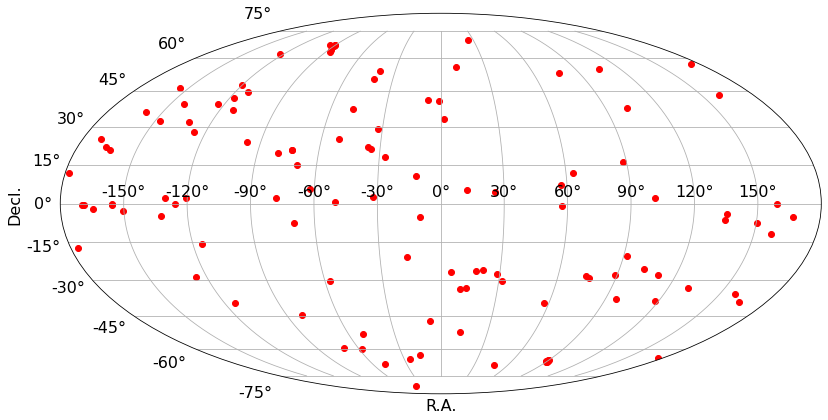

In [8]:
import matplotlib.pylab as plt
%matplotlib inline

plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111, projection='mollweide')

ra = np.radians(hdu.data['ra'])
dec = np.radians(hdu.data['dec'])

ra[ra > np.pi] = ra[ra > np.pi] - 2 * np.pi

ax.scatter(ra, dec, c='r')
ax.grid()
ax.set_xlabel('R.A.')
ax.set_ylabel('Decl.')
plt.show()

Once the file is created, you will then want to add it to the SAS where it will then be ingested into targetdb. The path for this is:

`/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/target/open_fiber/`

Within this directory will be multiple folders that will version the FITS files for commissioning and open fibers. Make sure to add your FITS file to the most recent version that has not yet been ingested into targetdb.

# Creating a FPS Design

Once the carton has been added to targetdb by the target selection team, now we can create a design using targets from our spectrophotometric carton. First, we will need to query targetdb and pull targets from the relative cartons. This will inclucde pulling targets within our field from comm_spectrophoto, but we will also want to select all sky and standards as well that will be included in the design. This is done below.

In [1]:
from sdssdb.peewee.sdss5db import targetdb

# connect to targetdb
targetdb.database.connect_from_parameters(user='sdss_user',
                                          host='localhost',
                                          port=7500)

True

In [2]:
from peewee import *
import numpy as np

# set search radius based on field size for APO or LCO
observatory = 'APO'
if observatory == 'APO':
    r_search = 1.49
else:
    r_search = 0.95

# specify the field center and position angle
racen = 269.59
deccen = 66.55
position_angle = 40.

# specify the commissioning cartons we want to consider
# for this example, we will also specify the pk, as there are 
# multiple standard cartons
cartons = ['comm_spectrophoto', 'ops_sky_boss', 'ops_sky_apogee',
           'ops_std_boss', 'ops_std_apogee']
cartons_pk = [648, 368, 325, 530, 532]

# get all of the targets in the commissioning carton near the field center
all_skies = (targetdb.Target.select(targetdb.Target.catalogid,
                                   targetdb.Target.ra,
                                   targetdb.Target.dec,
                                   targetdb.Target.pk,
                                   targetdb.CartonToTarget.priority,
                                   targetdb.CartonToTarget.value,
                                   targetdb.Cadence.label,
                                   targetdb.Carton.carton,
                                   targetdb.CartonToTarget.pk,
                                   targetdb.Magnitude.g,
                                   targetdb.Magnitude.r,
                                   targetdb.Magnitude.i,
                                   targetdb.Magnitude.z,
                                   targetdb.Magnitude.bp,
                                   targetdb.Magnitude.gaia_g,
                                   targetdb.Magnitude.rp,
                                   targetdb.Magnitude.j,
                                   targetdb.Magnitude.h,
                                   targetdb.Magnitude.k,
                                   targetdb.Category.label,
                                   targetdb.Carton.program,
                                   targetdb.Instrument.label)
                    .join(targetdb.CartonToTarget)
                    .join(targetdb.Cadence, JOIN.LEFT_OUTER)
                    .switch(targetdb.CartonToTarget)
                    .join(targetdb.Carton)
                    .join(targetdb.Category)
                    .switch(targetdb.CartonToTarget)
                    .join(targetdb.Magnitude, JOIN.LEFT_OUTER)
                    .switch(targetdb.CartonToTarget)
                    .join(targetdb.Instrument)
                    .where((targetdb.Carton.carton.in_(cartons)) & 
                           (targetdb.Target.cone_search(racen, deccen, r_search))))

# grab the results
catalogid, ra, dec, target_pk, priority, value, cadences, carton, carton_to_target_pk, g, r, i, z, bp, gaia_g, rp, j, h, k, category, program, instrument  = map(list, zip(*list(all_skies.tuples())))
catalogid = np.array(catalogid, dtype=np.int64)
ra = np.array(ra)
dec = np.array(dec)
target_pk = np.array(target_pk, dtype=np.int64)
priority = np.array(priority)
value = np.array(value)
carton = np.array(carton)
carton_to_target_pk = np.array(carton_to_target_pk)
category = np.array(category)
program = np.array(program)
instrument = np.char.upper(instrument)
magnitudes = np.zeros((len(g),10))
magnitudes[:, 0] = g
magnitudes[:, 1] = r
magnitudes[:, 2] = i
magnitudes[:, 3] = z
magnitudes[:, 4] = bp
magnitudes[:, 5] = gaia_g
magnitudes[:, 6] = rp
magnitudes[:, 7] = j
magnitudes[:, 8] = h
magnitudes[:, 9] = k

Next, we will want to create the design using using Robostrategy. To do this, we first need to estimate the x,y coordinates of the targets in the FBS plane use coordio. To do this, we will need to also specify the observation time of the design in Julian Days.

In [3]:
from coordio.utils import radec2wokxy
import robostrategy.obstime as obstime
import coordio.time

# specify observation time
ot = obstime.ObsTime(observatory=observatory.lower())
obsTime = coordio.time.Time(ot.nominal(lst=racen)).jd

# convert to x,y
x, y, fieldWarn, HA, PA_coordio = radec2wokxy(ra=ra,
                                              dec=dec,
                                              coordEpoch=np.array([2457174] * len(ra)),
                                              waveName=np.array(list(map(lambda x:x.title(), instrument))),
                                              raCen=racen,
                                              decCen=deccen,
                                              obsAngle=position_angle,
                                              obsSite=observatory,
                                              obsTime=obsTime)

[WARNING]: Warning! Wavelengths not supplied, defaulting to 6231 angstrom (CoordIOUserWarning)


To visualize our possible targets for the design, below is a plot of the possible targets in the FPS focal plane:

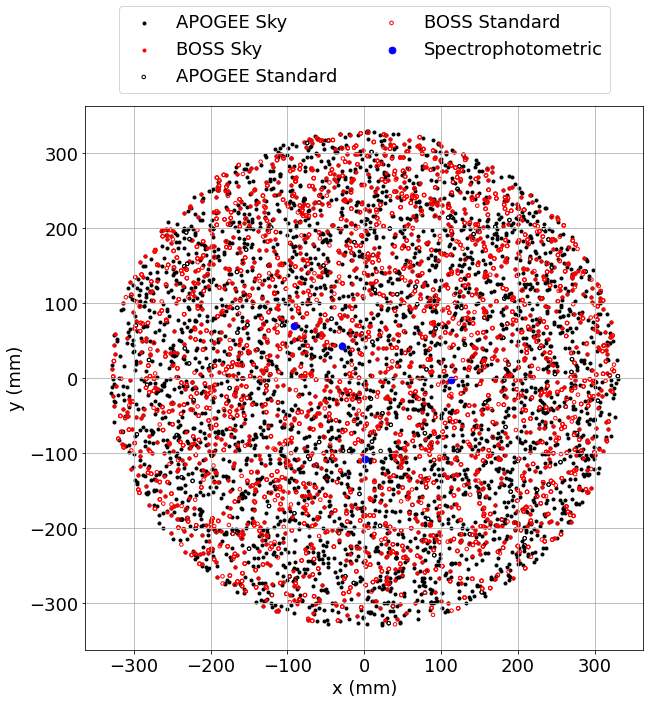

In [4]:
import matplotlib.pylab as plt
%matplotlib inline

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,10))
plt.scatter(x[(instrument == 'APOGEE') & (carton == 'ops_sky_apogee')],
            y[(instrument == 'APOGEE') & (carton == 'ops_sky_apogee')],
            c='k', marker='.', label='APOGEE Sky')
plt.scatter(x[(instrument == 'BOSS') & (carton == 'ops_sky_boss')],
            y[(instrument == 'BOSS') & (carton == 'ops_sky_boss')],
            c='r', marker='.', label='BOSS Sky')
plt.scatter(x[(instrument == 'APOGEE') & (carton == 'ops_std_apogee')],
            y[(instrument == 'APOGEE') & (carton == 'ops_std_apogee')],
            edgecolors='k', marker='.', label='APOGEE Standard', facecolors='none', s=50)
plt.scatter(x[(instrument == 'BOSS') & (carton == 'ops_std_boss')],
            y[(instrument == 'BOSS') & (carton == 'ops_std_boss')],
            edgecolors='r', marker='.', label='BOSS Standard', facecolors='none', s=50)
plt.scatter(x[(instrument == 'BOSS') & (carton == 'comm_spectrophoto')],
            y[(instrument == 'BOSS') & (carton == 'comm_spectrophoto')],
            c='b', marker='.', label='Spectrophotometric', s=180)
plt.grid()
plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.2))
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

Before making the design, we want to make sure that the targets in our carton are higher priority than the skies and standards. So, we will force all skies and standard priorties to be lower than the nominal value from our carton of 6080.

In [5]:
priority[carton != 'comm_spectrophoto'] = 10000

Now we can build our design. This will require building arrays for the `robostrategy.field.Field` object that need to have certain formatting and datatypes. This is demonstrated above for the multi-carton design we are trying to make.

In [6]:
import robostrategy.field as field
import roboscheduler.cadence as cadence
from sdssdb.peewee.sdss5db import targetdb

# connect to targetdb
targetdb.database.connect_from_parameters(user='sdss_user',
                                          host='localhost',
                                          port=7500)

# need to load cadences before building designs
cadence.CadenceList().fromdb(version='v1')

# set cadence. must be in list of loaded cadences
# set cadence here because NONEs currently for sky carton in targetdb
cad = 'bright_1x1'

# create the field object
f = field.Field(racen=racen, deccen=deccen, pa=position_angle,
                field_cadence=cad, observatory=observatory.lower())

# set the required skies, in this case all fibers
f.required_calibrations['sky_boss'] = [300]
f.required_calibrations['sky_apogee'] = [50]
f.required_calibrations['standard_boss'] = [20]
f.required_calibrations['standard_apogee'] = [20]

# create array for RS field
N = len(ra)
# these are datatypes from robostrategy.Field
targets_dtype = np.dtype([('ra', np.float64),
                          ('dec', np.float64),
                          ('epoch', np.float32),
                          ('pmra', np.float32),
                          ('pmdec', np.float32),
                          ('parallax', np.float32),
                          ('lambda_eff', np.float32),
                          ('delta_ra', np.float64),
                          ('delta_dec', np.float64),
                          ('magnitude', np.float32, 7),
                          ('x', np.float64),
                          ('y', np.float64),
                          ('within', np.int32),
                          ('incadence', np.int32),
                          ('priority', np.int32),
                          ('value', np.float32),
                          ('program', np.unicode_, 30),
                          ('carton', np.unicode_, 50),
                          ('category', np.unicode_, 30),
                          ('cadence', np.unicode_, 30),
                          ('fiberType', np.unicode_, 10),
                          ('catalogid', np.int64),
                          ('carton_to_target_pk', np.int64),
                          ('rsid', np.int64),
                          ('target_pk', np.int64),
                          ('rsassign', np.int32)])

# create an empty array
targs = np.zeros(N, dtype=targets_dtype)

# fill in the relevant columns
targs['ra'] = ra
targs['dec'] = dec
targs['epoch'] = np.zeros(N, dtype=np.float32) + 2015.5
targs['x'] = x
targs['y'] = y
targs['within'] = np.zeros(N, dtype=np.int32) + 1
targs['incadence'] = np.zeros(N, dtype=np.int32) + 1
targs['priority'] = priority
targs['value'] = value
targs['program'] = program
targs['carton'] = carton
targs['category'] = category
targs['cadence'] = np.array([cad] * N, dtype='<U30')
targs['fiberType'] = instrument
targs['lambda_eff'] = np.zeros(N, dtype=np.float32)
targs['lambda_eff'][targs['fiberType'] == 'APOGEE'] = 16000.
targs['lambda_eff'][targs['fiberType'] == 'BOSS'] = 5400.
targs['catalogid'] = catalogid
targs['carton_to_target_pk'] = carton_to_target_pk
targs['rsid'] = np.arange(N, dtype=np.int64) + 1
targs['target_pk'] = target_pk
targs['magnitude'] = magnitudes
targs['rsassign'] = np.zeros(N, dtype=np.int32) + 1

# assign targets
f.targets_fromarray(targs)

f.assign()

[WARNING]: failed to connect to database 'sdss5db': could not connect to server: Connection refused
	Is the server running on host "operations.sdss.org" (2001:1948:414:13::37) and accepting
	TCP/IP connections on port 5432?
could not connect to server: Connection refused
	Is the server running on host "operations.sdss.org" (155.101.19.37) and accepting
	TCP/IP connections on port 5432?

[WARNING]: Warning! Wavelengths not supplied, defaulting to 6231 angstrom (CoordIOUserWarning)
[WARNING]: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'. (FutureWarning)
[WARNING]: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison (FutureWarning)


You can print out the results of the assigments for the design to see how close Robostrategy got to the desired design.

In [7]:
print(f.assess())

Field cadence: bright_1x1

Calibration targets:
 sky_boss: 300/300
 standard_boss: 121/20
 sky_apogee: 50/50
 standard_apogee: 23/20

Science targets:
 BOSS targets assigned: 0
 APOGEE targets assigned: 0
 Targets per epoch: 0

Robots used:
 BOSS-only: 196
 APOGEE-BOSS: 298

Carton completion:
 comm_spectrophoto: 0 of 4




As we can see from the above, none of the targets were selected for a design. If we print out the magntiudes for the spectrophotometric standards:

In [8]:
targs['magnitude'][carton == 'comm_spectrophoto']

array([[10.662563 , 10.456802 , 10.408894 , 10.678806 , 10.451582 ,
        10.102316 ,  9.547    ],
       [13.99353  , 13.2260275, 13.10926  , 13.566797 , 13.049724 ,
        12.406114 , 11.09     ],
       [14.5862   , 13.828719 , 13.452742 , 14.257921 , 13.630381 ,
        12.887277 , 11.273    ],
       [11.832602 , 11.822098 , 11.85596  , 11.903628 , 11.774604 ,
        11.551409 , 11.219    ]], dtype=float32)

You can see that all sources are too bright to place a BOSS fiber on one. This is an example where you may need to change instruments are redo your carton selection.

With this bad design though, we will continue the example to illustrate the rest of the process. 

You can also plot the resulting assignments:

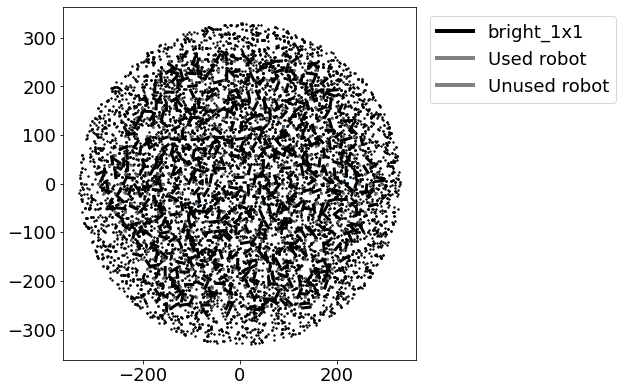

In [9]:
f.plot(iexp=0)

To save the design, you can then export it as a fits file.

In [10]:
f.tofits(filename='comm_specphoto_stands_example.fits')

# Adding Commissioning Design to targetdb

Finally, if you have created a design to your liking, you can validate the design once more using Mugatu. To do this, we will use the results of the above design to create a mugatu.FPSDesign object. Designs can be easily loaded directly from the fits file you created above

In [11]:
from mugatu.fpsdesign import FPSDesign

# create a mugatu.FPSDesign object that is specified as a manual design
fps_design = FPSDesign(design_pk=-1,
                       obsTime=obsTime,
                       design_file='comm_specphoto_stands_example.fits',
                       manual_design=True,
                       exp=0)

Once loaded you can validate the design. If no errors come up, your design is valid and passed all deadlock and collision tests!

In [12]:
fps_design.validate_design()

If any warnings come up (i.e. any assignment removed due to deadlocks or collisions), you can check which targets were removed by calling the below).

In [13]:
fps_design.targets_unassigned

[]

In [14]:
fps_design.targets_collided

[]